# NEURALPROPHET MODELS 1

In this notebook, we are going to fit NeuralProphet models by using the dataset without COVID data.

NeuralProphet emerges as a powerful and accessible tool to address time series prediction using neural networks. It is an open source library developed by Facebook, which combines simplicity of use with the ability to model and predict time series effectively. It is based on neural network architecture and leverages deep learning capabilities to capture complex patterns and make accurate predictions.

One of the distinctive advantages of NeuralProphet is its ease of use. Unlike other machine learning libraries, NeuralProphet is designed to be accessible even to those with no data science experience.

Moreover, it allows modelling of non-linear trends, seasonality, effects of events and changes in trend over time. It also includes external regressions, allowing for additional variables that may influence the time series data.

Another feature of NeuralProphet is its ability to automatically handle multiple model hyperparameters, such as neural network architecture selection, regularization and learning optimization. This reduces the workload for users and simplifies the model tuning process.

NeuralProphet consists of an additive model in which each time series is modeled as the combination of 6 components. Mathematically, this can be expressed as:

$$\hat{y}_t = T(t) + S(t) + E(t) + F(t) + A(t) + L(t),$$

where: 

* $T(t)$ is the trend component.
* $S(t)$ is the seasonal component.
* $E(t)$ represents the effects of holidays.
* $F(t)$ is the regression effects for future-known exogenous variables.
* $A(t)$ is the auto-regression e ects.
* $L(t)$ is the regression effects for lagged observations of exogenous variables.

### Trend component

$$T(t) = ( \delta_0 + a(t)^T\delta)t + (\rho_0 + a(t)^T\rho),$$

where:

* $\delta$ is a vector of growth rate adjustments.
* $\rho$ is a vector of offset adjustments.
* $\delta_0$ is the initial growth rate.
* $\rho_0$ is the initial displacement.
* $a(t)$ is a binary vector representing if time $t$ has passed each of the change points.

### Seasonal component

$$S(t) = \sum_{p \in P} S_p^*(t),$$

with 

$$
S^*_p(t) =
\begin{cases}
T(t) \cdot S_p(t), & \text{if } S_p \text{ is multiplicative} \\
S_p(t), & \text{otherwise}
\end{cases}
$$

and

$$
S_p(t) = \sum_{n=1}^{N} \left(a_n cos\left(\frac{2 \pi t n}{p}\right) + b_n sin\left(\frac{2 \pi t n}{p}\right)\right),
$$

where:

* $P$ is the set of all seasonalities.
* $N$ is the number of terms in the Fourier series.

### Holidays effects

We incorporate a list with the holidays in the model, assuming their effects are independent.

### Lagged regressors

$$
L(t) = \sum_{x \in X} L_x(x_{t-1}, x_{t-2}, \dots, x_{t-p}),
$$

where:

* X is a set of $m$ covariables of lenght $T$.

### Future regressors

$$
F(t) = \sum_{f \in \mathcal{F}} F^*_f(t),
$$

with

$$
F^*_f(t) =
\begin{cases}
T(t) \cdot d_f f(t), & \text{if } f \text{ is multiplicative} \\
d_f f(t), & \text{otherwise}
\end{cases},
$$

where:

* $F$ is the set of future regressions.
* $f(t)$ is the value of the future variable $f$ at time $t$.
* $d_f$ is the model coefficient corresponding to future return $f$.

### 📑 Index
* [1. FIRST NEURALPROPHET MODEL](#first_model)
* [2. SECOND NEURALPROPHET MODEL](#second_model)
* [3. MODEL WITH BEST PARAMETERS](#best1)
* [4. NEURALPROPHET MODEL 4](#best2)

Import the packages.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import itertools
import random
import torch
from neuralprophet import NeuralProphet
from pylab import rcParams
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=FutureWarning)

plt.style.use("fivethirtyeight")
light_style = {
    "figure.facecolor": "#d9effb",   
    "axes.facecolor": "#d9effb",
    "savefig.facecolor": "#d9effb",
    "axes.grid": True,
    "axes.grid.which": "both",
    "axes.spines.left": True,
    "axes.spines.right": True,
    "axes.spines.top": True,
    "axes.spines.bottom": True,
    "grid.color": "#a9d3f2",
    "grid.linewidth": "0.8",
    "text.color": "#333333",
    "axes.labelcolor": "#333333",
    "axes.labelweight": "black",  
    "xtick.color": "#333333",
    "ytick.color": "#333333",
    "font.size": 12,
    "axes.titleweight": "bold",  
    "legend.fontsize": 12,
    "legend.title_fontsize": 12,
}
plt.rcParams.update(light_style)
rcParams['figure.figsize'] = (18, 7)

Load the data and consider that our data set goes from 2003 to 2019 (without COVID). Consider the exogenous variable FLT ( total number of flights) as future regressor and create a new exogenous variable Revenue_Total as lagged regressor.

In [2]:
df = pd.read_csv(
    "C:/Users/Juanfran cd/Desktop/MATEMATICAS UA/TFG/air traffic.csv",
    encoding="ISO-8859-1",
)

# Clean and convert columns to number 
df["Pax"] = df["Pax"].str.replace(",", "", regex=True).astype(float)
df["Flt"] = df["Flt"].str.replace(",", "", regex=True).astype(float)
df["Dom_RPM"] = df["Dom_RPM"].str.replace(",", "", regex=True).astype(float)
df["Int_RPM"] = df["Int_RPM"].str.replace(",", "", regex=True).astype(float)

# Create date column in YYYY-MM format
df["Date"] = pd.to_datetime(
    df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2), format="%Y-%m"
)

# Create the new column 'Revenue_Total'
df["Revenue_Total"] = df["Dom_RPM"] + df["Int_RPM"]

# Filter data between 2003 and 2019 and select relevant columns
df1 = df.loc[df["Year"].between(2003, 2019), ["Date", "Pax", "Flt", "Revenue_Total"]].copy()

# Rename columns for NeuralProphet
df1 = df1.rename(columns={"Pax": "y", "Date": "ds"})

Split the data set into 2: a training set (from 2003 to 2017, that is 180 values) and a test set (from 2018 to 2019, that is 24 values).

In [3]:
train = df1.loc[df1["ds"] <= "2017-12-01"]
test = df1.loc[df1["ds"] >= "2018-01-01"]

train.shape, test.shape

((180, 4), (24, 4))

Make an error metrics function.

In [4]:
def EVAL_METRICS_FUNC(y_true, y_pred):
    def MAPE(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print("Metric evaluation result:-")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_pred)}")
    print(f"MAPE: {MAPE(y_true, y_pred)}")

<a id='first_model'></a>
## 1. FIRST NEURALPROPHET MODEL

At first, we make a model with default values.

In [5]:
# Fix seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

m = NeuralProphet()

# Train the model
m.fit(train[["ds", "y"]], freq="M")

# Make future dataframe
m_future = m.make_future_dataframe(train[["ds", "y"]], periods=24, n_historic_predictions=True)

# Forecasting
forecast = m.predict(m_future)
forecast[['ds', 'yhat1']]


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (12) is too small than the required number                     for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 24 rows at the end with NaNs in 'y' column.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,yhat1
0,2003-01-01,45974040.0
1,2003-02-01,43403176.0
2,2003-03-01,56161472.0
3,2003-04-01,53620376.0
4,2003-05-01,56163904.0
...,...,...
199,2019-08-01,82325440.0
200,2019-09-01,72073360.0
201,2019-10-01,76934432.0
202,2019-11-01,73704136.0


Plot of forecasting

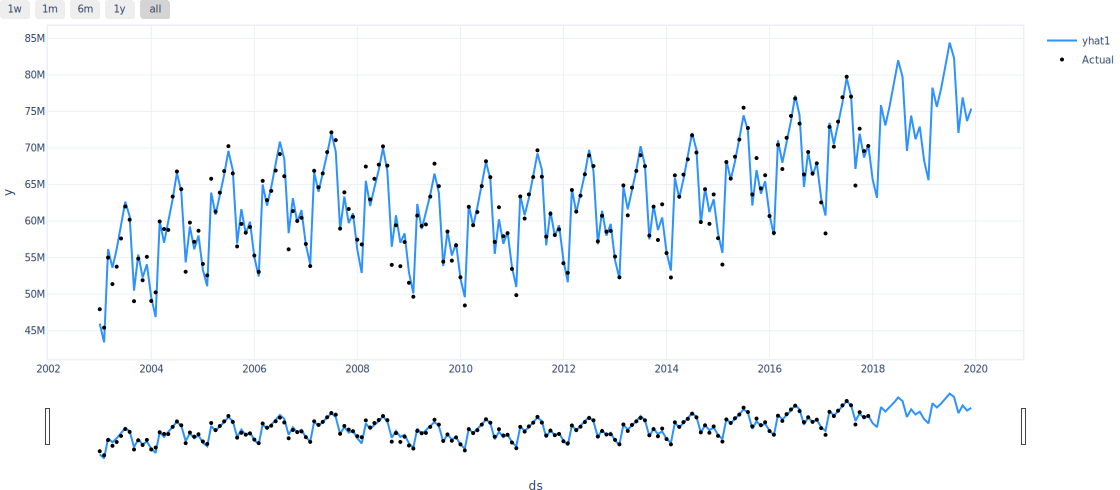

In [6]:
m.set_plotting_backend("plotly-static")
m.plot(forecast, figsize=(16, 7))

The model with default values correctly captures annual seasonal patterns and adapts appropriately to the growing trend. However, although the overall adjustment is good, there are some point deviations between the forecast and the actual values, especially in very sharp peaks or falls.

Plot of forecasting and components

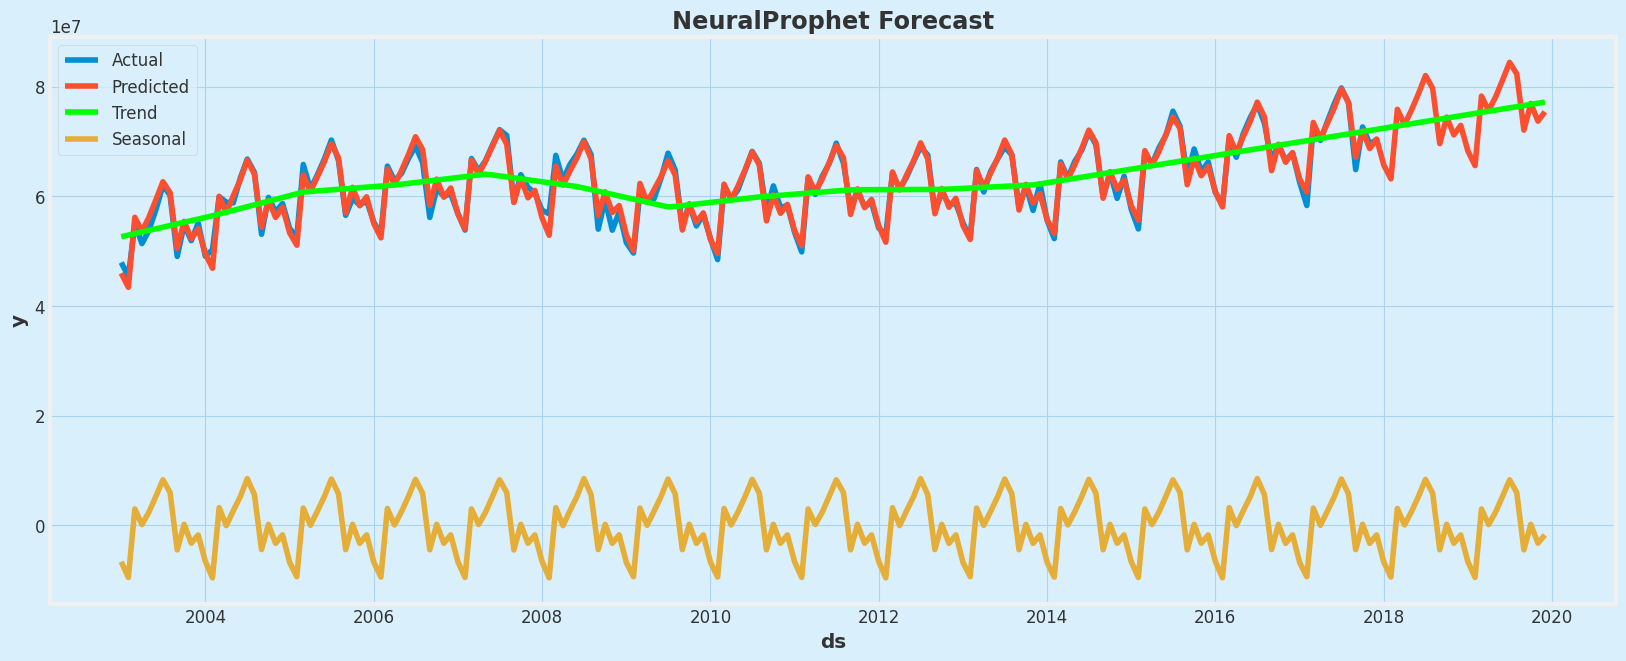

In [7]:
sns.lineplot(data=forecast, x="ds", y="y", label="Actual")
sns.lineplot(data=forecast, x="ds", y="yhat1", label="Predicted")
sns.lineplot(data=forecast, x="ds", y="trend", label="Trend", color="lime")
sns.lineplot(data=forecast, x="ds", y="season_yearly", label="Seasonal")
plt.title("NeuralProphet Forecast")
plt.show()

In this graph, the forecast of the target variable and its real values are represented, together with the decomposition of the main components of the model: trend and annual seasonality. The combination of appropriate fit, consistent trend and well-defined seasonality confirms that the model has correctly learned the internal series structures.

Plot of internal parameters of the trained model: trend, trend rate change y seasonality (yearly).

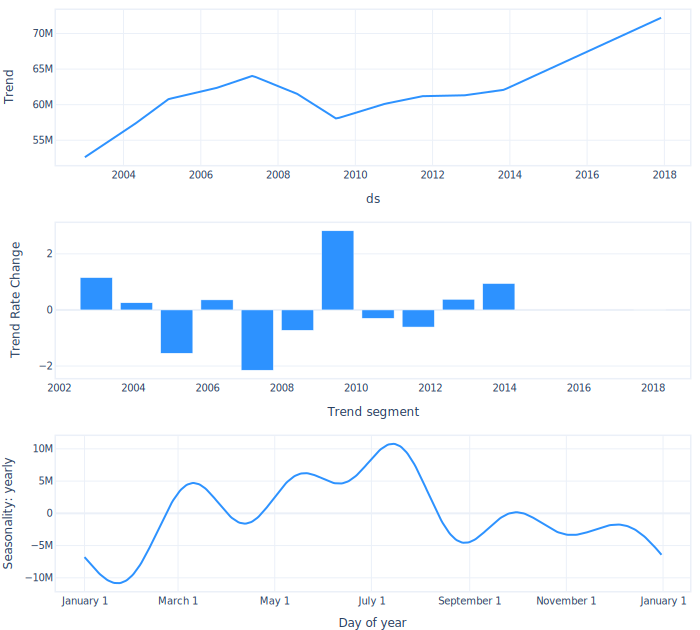

In [8]:
m.plot_parameters()

This graph shows an overview of the internal parameters of the trained model: trend, trend rate change and seasonality (yearly). 

1. Trend: There is a slight increase from 2003 to 2007, a slight decrease between 2008 and 2010, and then a continuous recovery until 2018. 

2. Trend Rate Change: represents changes in the slope of the trend (i.e., accelerations or decelerations). There are clear peaks of change around 2004 and 2010 (acceleration), and decelerations between 2005-2009. 

3. Seasonality (yearly): the pattern is very clear: there is a minimum in January, a maximum in July and another lower peak in spring. This indicates that the model has detected more activity in summer and less in winter.

#### Error Metrics

In [9]:
train[["yhat"]] = (
    forecast[["yhat1"]].iloc[:180].values
)
test.loc[:, ["yhat"]] = (
    forecast[["yhat1"]].iloc[-24:].values
)

For train set

In [10]:
y_true = train["y"].values
y_pred = train["yhat"].values
EVAL_METRICS_FUNC(y_true, y_pred)

Metric evaluation result:-
MAE: 801831.7444444444
MAPE: 1.3461283200907455


For test set

In [11]:
y_true = test["y"].values
y_pred = test["yhat"].values
EVAL_METRICS_FUNC(y_true, y_pred)

Metric evaluation result:-
MAE: 1515086.0416666667
MAPE: 1.9816714452807458


Another plot of forecasting

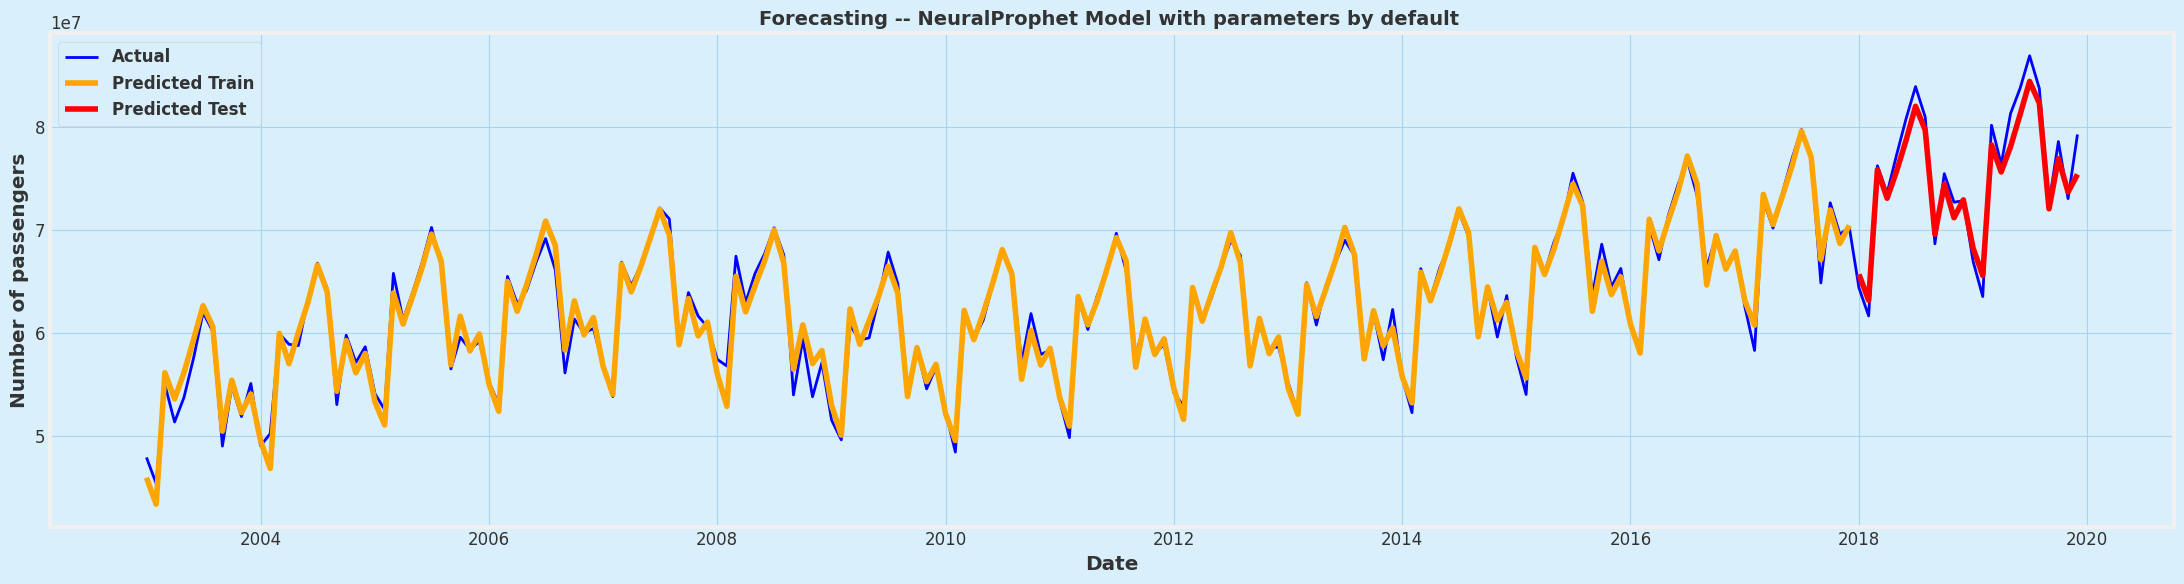

In [13]:
plt.figure(figsize=(22, 6))
plt.plot(df1["ds"], df1["y"], label="Actual", color="blue", linewidth=2)
plt.plot(train["ds"], train["yhat"], label="Predicted Train", color="orange")
plt.plot(test["ds"], test["yhat"], label="Predicted Test", color="red")
plt.title("Forecasting -- NeuralProphet Model with parameters by default ", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of passengers")
legend = plt.legend()
for text in legend.get_texts():
    text.set_fontweight('bold')
plt.grid(True)
plt.tight_layout()
plt.savefig("../graphics/Neuralprophet_sin_covid/default_sin_covid", dpi=300, bbox_inches="tight")
plt.show()

<a id='second_model'></a>
## 2. SECOND NEURALPROPHET MODEL

Firstly, let's adjust the main parameters manually in the model.

#### *Trend parameters*

1. trend_reg: regularization of the trend. The larger, the more rigid the trend
2. trend_reg_treshold: checks whether small trend changes are removed. With *True*, it deletes small trend changes.

In [14]:
# Create a model with control over the trend
m_trend = NeuralProphet(
    trend_reg=1,                
    trend_reg_threshold=True,   
)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.


In [15]:
# Fit the model
m_trend.fit(train[["ds", "y"]], freq="M")

# Forecasting
future_trend = m_trend.make_future_dataframe(train[["ds", "y"]], periods=24, n_historic_predictions=True)
forecast_trend = m_trend.predict(future_trend)
forecast_trend[['ds', 'yhat1']]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (12) is too small than the required number                     for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 24 rows at the end with NaNs in 'y' column.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,yhat1
0,2003-01-01,51347632.0
1,2003-02-01,48497816.0
2,2003-03-01,60918072.0
3,2003-04-01,58008432.0
4,2003-05-01,60124388.0
...,...,...
199,2019-08-01,82492792.0
200,2019-09-01,72349952.0
201,2019-10-01,77151760.0
202,2019-11-01,73868576.0


#### *Seasonality parameters*

1. yearly_seasonality: True/False
2. weekly_seasonality: True/False
3. daily_seasonality: True/False
4. seasonality_mode: additive/multiplicative

In [16]:
# Create model with control over seasonality
m_seasonality = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

In [17]:
# Fit the model
m_seasonality.fit(train[["ds", "y"]], freq="M")

# Forecasting
future_seasonality = m_seasonality.make_future_dataframe(train[["ds", "y"]], periods=24, n_historic_predictions=True)
forecast_seasonality = m_seasonality.predict(future_seasonality)
forecast_seasonality[['ds', 'yhat1']]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (12) is too small than the required number                     for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 24 rows at the end with NaNs in 'y' column.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,yhat1
0,2003-01-01,49837808.0
1,2003-02-01,48829260.0
2,2003-03-01,54327428.0
3,2003-04-01,53450564.0
4,2003-05-01,54785252.0
...,...,...
199,2019-08-01,86265808.0
200,2019-09-01,68859936.0
201,2019-10-01,77047328.0
202,2019-11-01,71481904.0


#### *Auto-regression parameters*

1. n_lags: it indicates how many past values of the series are used as predictor variables.

<Figure size 1200x600 with 0 Axes>

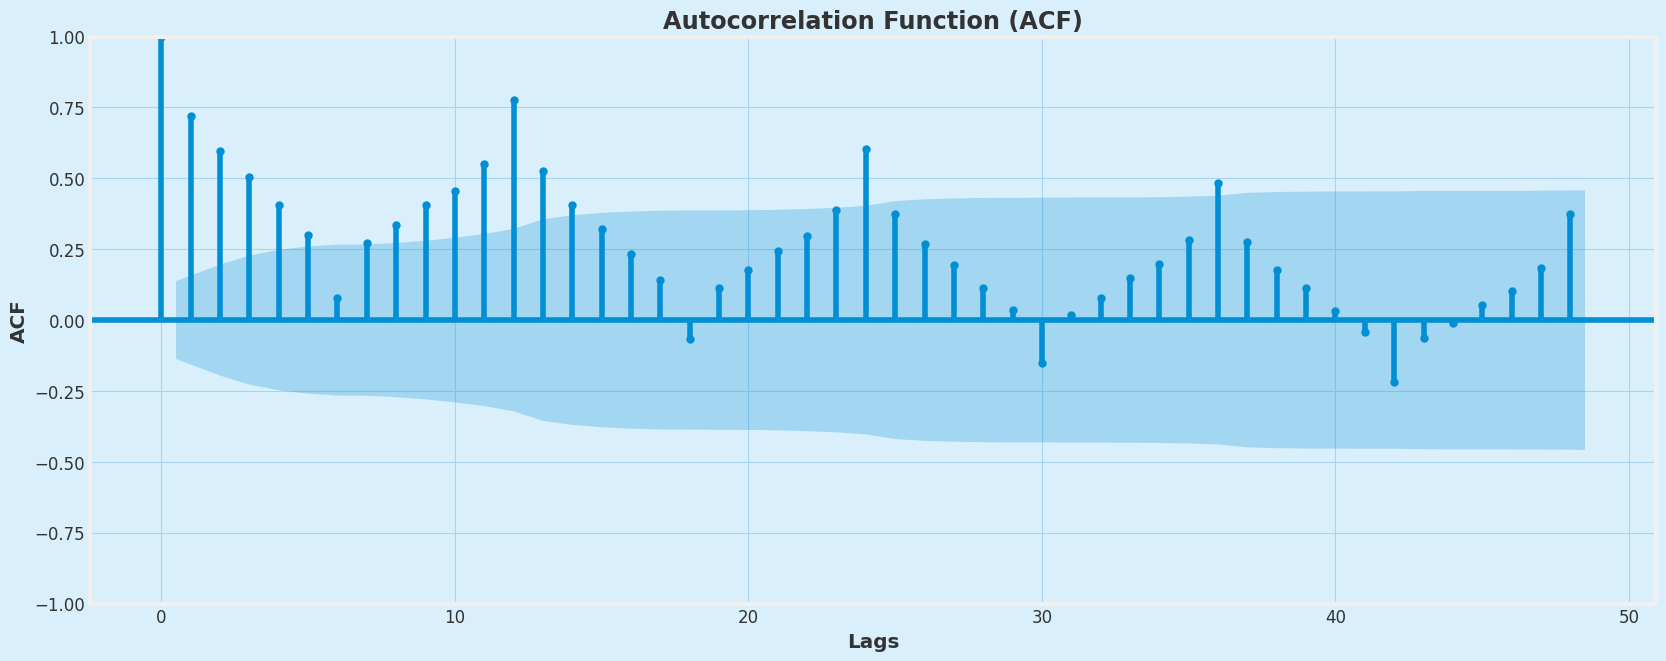

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plot_acf(df1["y"], lags=48)  
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lags")
plt.ylabel("ACF")
plt.grid(True)
plt.show()

In this graph, we can observe a strong temporal dependence on the first lags, especially in the first twelve months. In addition, there is a fluctuating behaviour with peaks every 12 months, which confirms the presence of an annual seasonality. Therefore, we will take n_lags = 12.

In [19]:
# Create model with control over auto-regression
m_auto = NeuralProphet(
    n_lags=12
)

In [20]:
# Fit the model
m_auto.fit(train[["ds", "y"]], freq="M")

# Forecasting
future_auto = m_auto.make_future_dataframe(train[["ds", "y"]], periods=24, n_historic_predictions=True)
forecast_auto = m_auto.predict(future_auto)
forecast_auto[['ds', 'yhat1']]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (11) is too small than the required number                     for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
WARNING - (NP.data.splitting._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.448]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.448]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in 'y' column.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,yhat1
0,2003-01-01,NaN
1,2003-02-01,NaN
2,2003-03-01,NaN
3,2003-04-01,NaN
4,2003-05-01,NaN
...,...,...
176,2017-09-01,66586096.0
177,2017-10-01,70651848.0
178,2017-11-01,68145616.0
179,2017-12-01,70688352.0


#### *Exogenous regressors*

1. add_future_regressor: to include known future regressions.
2. add_lagged_regressor: to include regressors only known in the past.

In [21]:
# Create model only with exogenous regressors
m_regressors = NeuralProphet()

# Add FUTURE regressor (also known in the future)
m_regressors.add_future_regressor(name="Flt")

# Add LAGGED regressor (only used in training and historical prediction)
m_regressors.add_lagged_regressor("Revenue_Total")

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', but there is no lags for Autoregression. Number of lags for regressor is automatically set to 1


In [22]:
# Fit the model
m_regressors.fit(train[["ds", "y", "Flt", "Revenue_Total"]], freq="M")

# Make future dataframe with regressors
future_regressors = m_regressors.make_future_dataframe(
    df=df1[["ds", "y", "Flt", "Revenue_Total"]],
    periods=0,
    n_historic_predictions=True
)

# Forecasting
forecast_regressors = m_regressors.predict(future_regressors)
forecast_regressors[['ds', 'yhat1']]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (12) is too small than the required number                     for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.data.splitting._make_future_dataframe) - Not extending df into future as no periods specified. You can skip this and predict directly instead.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.512]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in future regressors.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,yhat1
0,2003-01-01,NaN
1,2003-02-01,42972244.0
2,2003-03-01,55790184.0
3,2003-04-01,51989388.0
4,2003-05-01,54254476.0
...,...,...
198,2019-07-01,87164776.0
199,2019-08-01,85016928.0
200,2019-09-01,74865120.0
201,2019-10-01,80233408.0


#### *Training parameters*

1. epochs: number of training periods.
2. learning_rate: learning rate of the optimizer.
3. batch_size
4. early_stopping:to stop training if the error does not improve.

In [23]:
# Create model with control over training
m_training = NeuralProphet()

In [24]:
# Fit the model
m_training.fit(
    train[["ds", "y"]],
    freq="M",
    epochs=200,
    batch_size=32,
    learning_rate=0.01,
    early_stopping=True
)

# Forecasting
future_training = m_training.make_future_dataframe(train[["ds", "y"]], periods=24, n_historic_predictions=True)
forecast_training = m_training.predict(future_training)
forecast_training[['ds', 'yhat1']]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 24 rows at the end with NaNs in 'y' column.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,yhat1
0,2003-01-01,50133276.0
1,2003-02-01,47546308.0
2,2003-03-01,59895168.0
3,2003-04-01,57355004.0
4,2003-05-01,59553608.0
...,...,...
199,2019-08-01,82025296.0
200,2019-09-01,71724296.0
201,2019-10-01,76690808.0
202,2019-11-01,73307600.0


Thus, let's adjust a model with all pararameters.

In [25]:
# Fix seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Define the model with all components
m1 = NeuralProphet(
    trend_reg=1,
    trend_reg_threshold=True,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    n_lags=12
)

# Add regressors
m1.add_future_regressor(name="Flt")             
m1.add_lagged_regressor("Revenue_Total")         

# Train the model
m1.fit(
    df1[["ds", "y", "Flt", "Revenue_Total"]],
    freq="M",
    epochs=200,
    batch_size=32,
    learning_rate=0.01,
    early_stopping=True
)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (12)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.462822,0.0,2.334116e+07,2.963134e+07,0.462822,0.0,0
1,0.420896,0.0,2.139144e+07,2.799395e+07,0.420896,0.0,1
2,0.394017,0.0,2.014663e+07,2.668052e+07,0.394017,0.0,2
3,0.379300,0.0,1.938806e+07,2.590645e+07,0.379300,0.0,3
4,0.368059,0.0,1.880307e+07,2.514947e+07,0.368059,0.0,4
...,...,...,...,...,...,...,...
195,0.003518,0.0,1.370708e+06,1.836416e+06,0.003518,0.0,195
196,0.003517,0.0,1.370624e+06,1.827369e+06,0.003517,0.0,196
197,0.003516,0.0,1.370431e+06,1.813758e+06,0.003516,0.0,197
198,0.003515,0.0,1.370130e+06,1.821515e+06,0.003515,0.0,198


In [26]:
# Make future dataframe with regressors
future_m1 = m1.make_future_dataframe(
    df=df1[["ds", "y", "Flt", "Revenue_Total"]],
    periods=0,  
    n_historic_predictions=True
)

# Forecasting
forecast_m1 = m1.predict(future_m1)
forecast_m1[['ds', 'yhat1']]

WARNING - (NP.data.splitting._make_future_dataframe) - Not extending df into future as no periods specified. You can skip this and predict directly instead.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.512]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in future regressors.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,yhat1
0,2003-01-01,NaN
1,2003-02-01,NaN
2,2003-03-01,NaN
3,2003-04-01,NaN
4,2003-05-01,NaN
...,...,...
198,2019-07-01,86809216.0
199,2019-08-01,82823640.0
200,2019-09-01,71833520.0
201,2019-10-01,78344144.0


#### Error Metrics

In [27]:
train["yhat1"] = forecast_m1["yhat1"].iloc[:180].values
test["yhat1"] = forecast_m1["yhat1"].iloc[-24:].values

For train set

In [28]:
train_valid = train[~train["yhat1"].isna()].copy()
y_true = train_valid["y"].values
y_pred = train_valid["yhat1"].values
EVAL_METRICS_FUNC(y_true, y_pred)

Metric evaluation result:-
MAE: 1430479.375
MAPE: 2.307756095012123


For test set

In [29]:
y_true_test = test["y"].values
y_pred_test = test["yhat1"].values
EVAL_METRICS_FUNC(y_true_test, y_pred_test)

Metric evaluation result:-
MAE: 5443147.125
MAPE: 7.331086204401569


Plot of forecasting and components

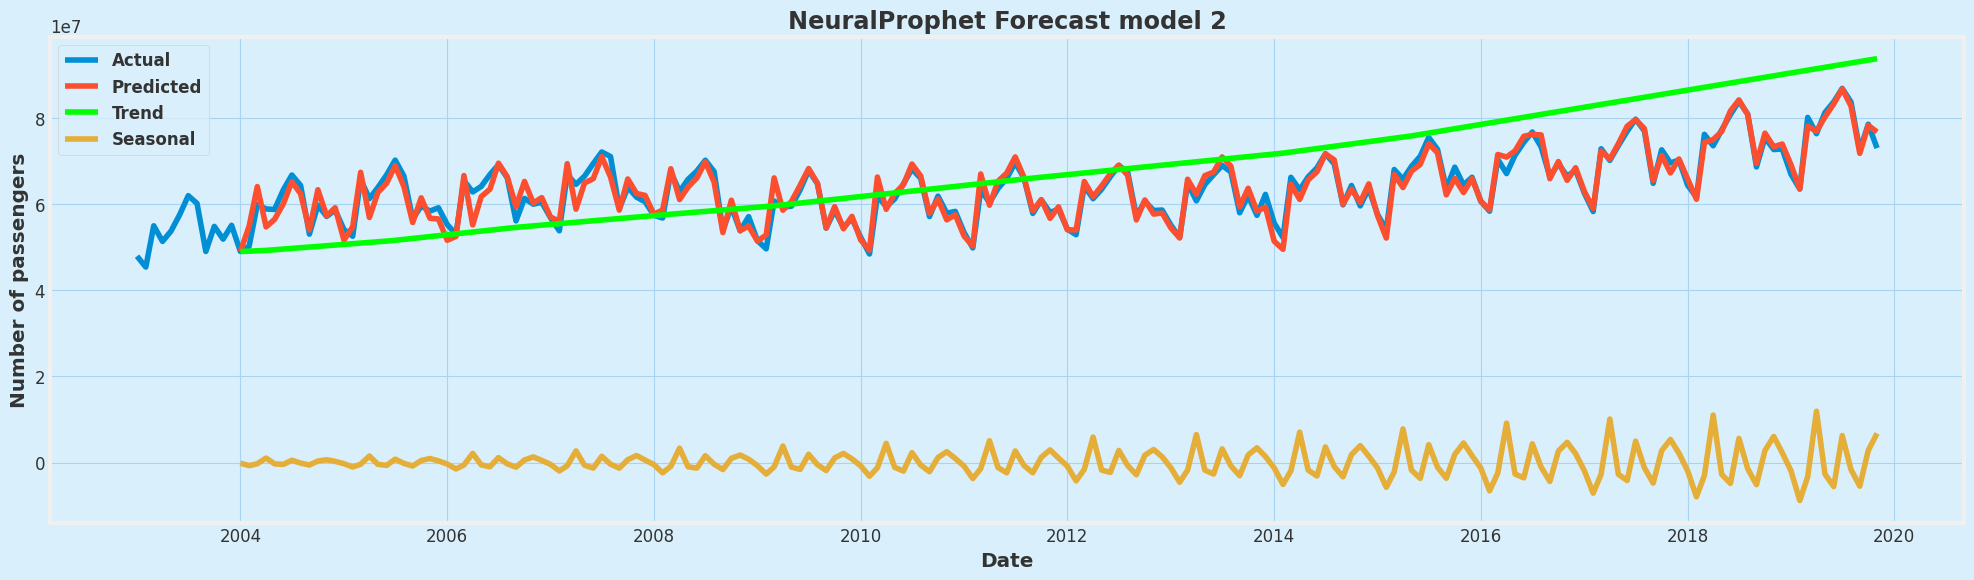

In [30]:
plt.figure(figsize=(22,6))  
sns.lineplot(data=forecast_m1, x="ds", y="y", label="Actual")
sns.lineplot(data=forecast_m1, x="ds", y="yhat1", label="Predicted")
sns.lineplot(data=forecast_m1, x="ds", y="trend", label="Trend", color="lime")
sns.lineplot(data=forecast_m1, x="ds", y="season_yearly", label="Seasonal")
plt.title("NeuralProphet Forecast model 2") 
plt.xlabel("Date")
plt.ylabel("Number of passengers")
legend = plt.legend()
for text in legend.get_texts():
    text.set_fontweight('bold')
plt.show()


<a id='best1'></a>
## 3. MODEL WITH BEST PARAMETERS

Initially, a hyperparameter grid (param_grid) is defined with multiple options for the NeuralProphet model. This results in a total of 2304 possible combinations. 

However, executing all this involves a large computational cost. Therefore, a random search is carried out, randomly selecting 200 combinations from the total.

In [ ]:
param_grid = {
    "trend_reg": [0, 1, 5],
    "trend_reg_threshold": [False, True],
    "yearly_seasonality": [True],
    "seasonality_mode": ["additive", "multiplicative"],
    "n_lags": [0, 12, 24],
    "learning_rate": [0.01, 0.001],
    "batch_size": [32, 64],
    "epochs": [100, 150],
    "use_future_regressor": [False, True],
    "use_lagged_regressor": [False, True],
    "loss_func": ["Huber", "MSE"]
}

# Generate all possible combinations of parameters
all_params = [
    dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())
]

# Select 200 random combinations
num_models = 200
random_params = random.sample(all_params, num_models)

results = []

# Training and evaluating each model
for params in random_params:
    try:
        df_train = train[["ds", "y"]].copy()

        model = NeuralProphet(
            trend_reg=params["trend_reg"],
            trend_reg_threshold=params["trend_reg_threshold"],
            yearly_seasonality=params["yearly_seasonality"],
            seasonality_mode=params["seasonality_mode"],
            n_lags=params["n_lags"],
            loss_func=params["loss_func"]
        )

        if params["use_future_regressor"]:
            model.add_future_regressor("Flt")
            df_train["Flt"] = train["Flt"]

        if params["use_lagged_regressor"]:
            model.add_lagged_regressor("Revenue_Total")
            df_train["Revenue_Total"] = train["Revenue_Total"]

        if len(df_train) <= params["n_lags"] + 1:
            raise ValueError(f"No hay suficientes datos para n_lags={params['n_lags']}")

        # Fit the model
        model.fit(
            df_train,
            freq="M",
            epochs=params["epochs"],
            learning_rate=params["learning_rate"],
            batch_size=params["batch_size"],
            early_stopping=True
        )

        # Forecasting
        df_pred = df1[["ds", "y"]].copy()
        if params["use_future_regressor"]:
            df_pred["Flt"] = df1["Flt"]
        if params["use_lagged_regressor"]:
            df_pred["Revenue_Total"] = df1["Revenue_Total"]

        future = model.make_future_dataframe(df=df_pred, periods=0, n_historic_predictions=True)
        forecast = model.predict(future)

        # Evaluating
        df_aligned = df_pred.loc[forecast.index]
        valid_idx = forecast["yhat1"].notna()
        y_true = df_aligned["y"].values[valid_idx]
        y_pred = forecast["yhat1"].values[valid_idx]
        mse = mean_squared_error(y_true, y_pred)

        results.append({
            "params": params,
            "mse": mse
        })

    except Exception as e:
        print(f"❌ Error con parámetros:\n{params}\n{e}\n")
        results.append({
            "params": params,
            "mse": np.inf,
            "error": str(e)
        })

# Show the best combination
best = sorted(results, key=lambda x: x["mse"])[0]

print("🔍 Best combination found:")
print(best["params"])
print(f"MSE: {best['mse']:.2f}")

🔍 Best combination found:
* trend_reg: 1 
* trend_reg_threshold: False 
* yearly_seasonality: True
* seasonality_mode: multiplicative
* n_lags: 12
* learning_rate: 0.01 
* batch_size: 32 
* epochs: 150 
* use_future_regressor: True
* use_lagged_regressor: False
* loss_func: MSE

In [31]:
# Fix seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

m2 = NeuralProphet(
    trend_reg=1,
    trend_reg_threshold=False,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    n_lags=12,
    loss_func="MSE"
)

# Add regressors
m2.add_future_regressor(name="Flt")              

# Fit the model
m2.fit(
    train[["ds", "y", "Flt"]],
    freq="M",
    epochs=150,
    batch_size=32,
    learning_rate=0.01,
    early_stopping=True
)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,1.284674,0.0,2.353518e+07,32775064.00,1.217184,0.0,0
1,1.217351,0.0,2.435617e+07,34145076.00,1.345952,0.0,1
2,1.163091,0.0,2.242065e+07,31015394.00,1.092539,0.0,2
3,1.109680,0.0,2.165320e+07,30979320.00,1.106870,0.0,3
4,1.052224,0.0,2.129704e+07,30357882.00,1.040538,0.0,4
...,...,...,...,...,...,...,...
124,0.006445,0.0,1.833547e+06,2437768.75,0.005969,0.0,124
125,0.006438,0.0,1.906106e+06,2607646.75,0.006488,0.0,125
126,0.006433,0.0,1.861076e+06,2461646.75,0.005943,0.0,126
127,0.006426,0.0,1.904230e+06,2590878.50,0.006468,0.0,127


In [32]:
# Make future dataframe with regressors
future_m2 = m2.make_future_dataframe(
    df=df1[["ds", "y", "Flt"]],
    periods=0,  
    n_historic_predictions=True
)

# Forecasting
forecast_m2 = m2.predict(future_m2)
forecast_m2[['ds', 'yhat1']]

WARNING - (NP.data.splitting._make_future_dataframe) - Not extending df into future as no periods specified. You can skip this and predict directly instead.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.512]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in future regressors.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,yhat1
0,2003-01-01,NaN
1,2003-02-01,NaN
2,2003-03-01,NaN
3,2003-04-01,NaN
4,2003-05-01,NaN
...,...,...
198,2019-07-01,83757816.0
199,2019-08-01,82628952.0
200,2019-09-01,71212064.0
201,2019-10-01,75480448.0


#### Error Metrics

In [33]:
train["yhat2"] = forecast_m2["yhat1"].iloc[:180].values
test["yhat2"] = forecast_m2["yhat1"].iloc[-24:].values

For train set

In [34]:
train2_valid = train[~train["yhat2"].isna()].copy()
y_true = train2_valid["y"].values
y_pred = train2_valid["yhat2"].values
EVAL_METRICS_FUNC(y_true, y_pred)

Metric evaluation result:-
MAE: 1930442.8154761905
MAPE: 3.150774180660122


For test set

In [35]:
# Errores en test
y_true_test = test["y"].values
y_pred_test = test["yhat2"].values
EVAL_METRICS_FUNC(y_true_test, y_pred_test)

Metric evaluation result:-
MAE: 5660763.458333333
MAPE: 7.420237821987423


<a id='best2'></a>
## 4. NEURALPROPHET MODEL 4

In [36]:
# Fix seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

m3 = NeuralProphet()

# Add regressors
m3.add_future_regressor(name="Flt")              

# Fit the model
m3.fit(
    train[["ds", "y", "Flt"]],
    freq="M",
    epochs=1000
)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.444]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (12) is too small than the required number                     for the learning rate finder (211). The results might not be optimal.


Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
0,0.612070,0.0,2.649238e+07,3.173410e+07,0.590664,0.0,0
1,0.547289,0.0,2.398951e+07,3.001318e+07,0.528461,0.0,1
2,0.487546,0.0,2.219287e+07,2.805295e+07,0.485845,0.0,2
3,0.437683,0.0,2.078111e+07,2.684293e+07,0.448276,0.0,3
4,0.391908,0.0,2.045584e+07,2.607055e+07,0.430309,0.0,4
...,...,...,...,...,...,...,...
995,0.001173,0.0,6.648451e+05,8.348758e+05,0.001155,0.0,995
996,0.001171,0.0,6.630252e+05,8.538550e+05,0.001166,0.0,996
997,0.001171,0.0,6.691460e+05,8.507352e+05,0.001153,0.0,997
998,0.001170,0.0,6.795532e+05,8.603031e+05,0.001215,0.0,998


In [37]:
# Make future dataframe with regressors
future_m3 = m2.make_future_dataframe(
    df=df1[["ds", "y", "Flt"]],
    periods=0,  
    n_historic_predictions=True
)

# Forecasting
forecast_m3 = m3.predict(future_m3)
forecast_m3[['ds', 'yhat1']]

WARNING - (NP.data.splitting._make_future_dataframe) - Not extending df into future as no periods specified. You can skip this and predict directly instead.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.51]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,yhat1
0,2003-01-01,47574868.0
1,2003-02-01,42986264.0
2,2003-03-01,55756880.0
3,2003-04-01,52580356.0
4,2003-05-01,54966524.0
...,...,...
199,2019-08-01,83966016.0
200,2019-09-01,73895584.0
201,2019-10-01,79148352.0
202,2019-11-01,75395856.0


#### Error Metrics

In [38]:
train["yhat3"] = forecast_m3["yhat1"].iloc[:len(train)].values
test["yhat3"] = forecast_m3["yhat1"].iloc[-24:].values

For train set

In [39]:
train1_valid = train[~train["yhat3"].isna()].copy()
y_true = train1_valid["y"].values
y_pred = train1_valid["yhat3"].values
EVAL_METRICS_FUNC(y_true, y_pred)

Metric evaluation result:-
MAE: 670034.4777777778
MAPE: 1.1092793257201767


For test set

In [40]:
y_true_test = test["y"].values
y_pred_test = test["yhat3"].values
EVAL_METRICS_FUNC(y_true_test, y_pred_test)

Metric evaluation result:-
MAE: 1037427.2916666666
MAPE: 1.4465100508673157


Plot of forecasting

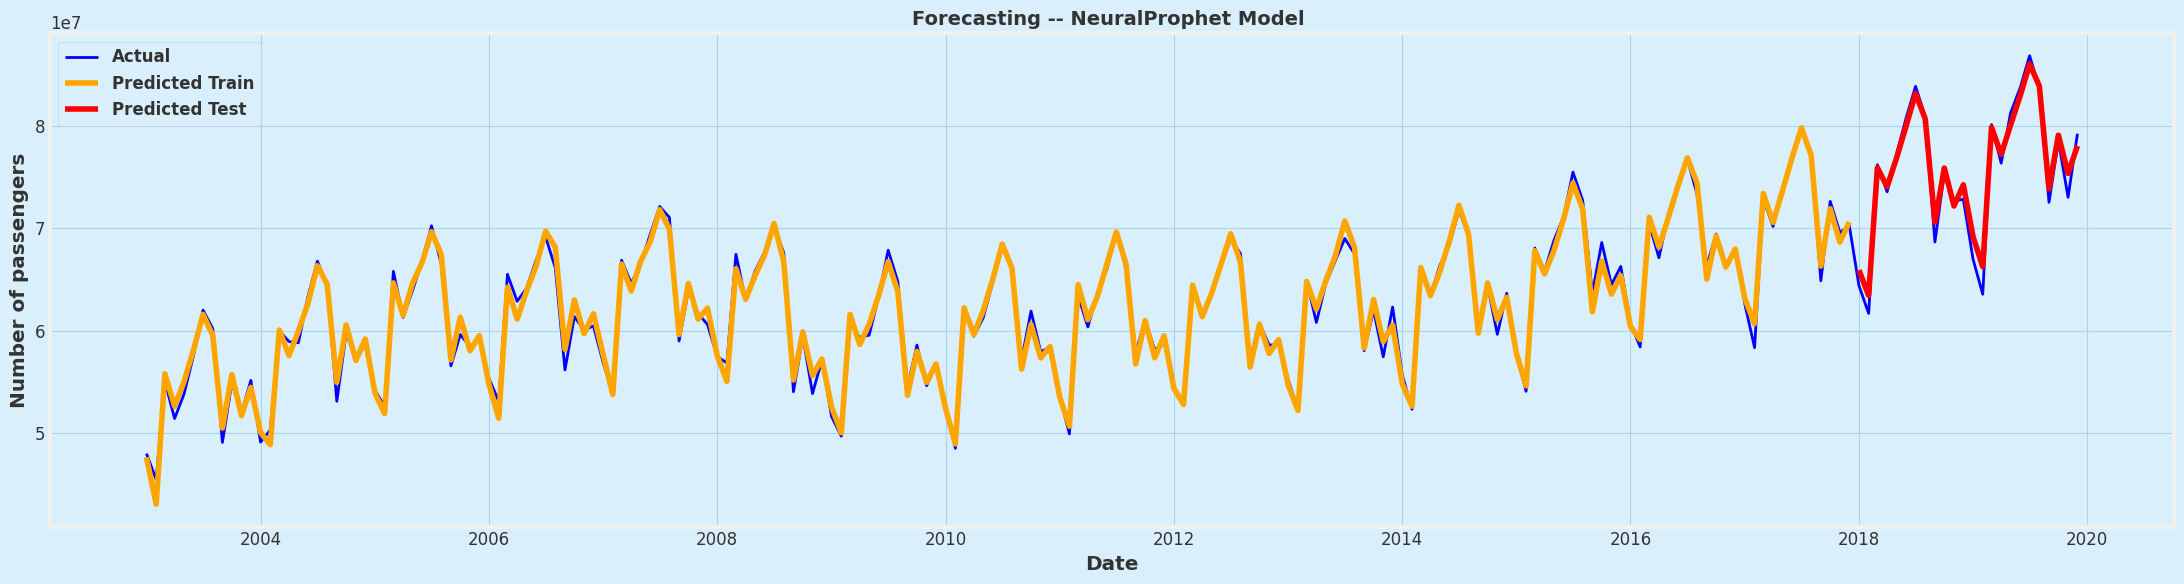

In [41]:
plt.figure(figsize=(22, 6))
plt.plot(forecast_m3["ds"], forecast_m3["y"], label="Actual", color="blue", linewidth=2)
plt.plot(train["ds"], train["yhat3"], label="Predicted Train", color="orange")
plt.plot(test["ds"], test["yhat3"], label="Predicted Test", color="red")
plt.title("Forecasting -- NeuralProphet Model ", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of passengers")
legend = plt.legend()
for text in legend.get_texts():
    text.set_fontweight('bold')
plt.grid(True)
plt.tight_layout()
plt.savefig("../graphics/Neuralprophet_sin_covid/best_sin_covid", dpi=300, bbox_inches="tight")
plt.show()

Plot of parameters

In [42]:
fig = m3.plot_parameters()
fig.write_image("../graphics/Neuralprophet_sin_covid/best_params_sin_covid.png", scale=2)
fig.show()

1. Trend: we can see a clear growth between 2003 and 2018, with slight decelerations in 2009 and 2011. We see that the model is well adapted to the trend of the data. 

2. Trend Rate Change: show how much the slope of the trend changes in each segment. In general, the changes are not very abrupt except that in 2008-2009 there is a clear fall, followed by a strong rise in 2010. 

3. Seasonality (yearly): there are highs between May-July (summer) and lows in January and October (winter and early autumn), behaviour that makes sense in passenger air traffic. 

4. Future regressor: this large blue rectangle indicates that the model has learned that the Flt regresor has a significant and positive impact on passenger number prediction.